In [24]:
from processing.preprocessing import BCIDataProcessor
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

In [25]:
recording_path_1 = '../recordings/recording_ssvep1.raw.fif'
recording_path_2 = '../recordings/recording_ssvep2.raw.fif'
recording_path_3 = '../recordings/recording_ssvep4_gel.raw.fif'
rescale = True
window_size = 2
window_overlap = 1.5
filter_method = 'fir'
l_freq, h_freq = 7, 31

processor = BCIDataProcessor(recording_path_2, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale, filter_method=filter_method)
data = processor.process()
data

{'11.0': array([[[ 4.57631618e-17, -3.54051293e-05, -6.20546344e-05, ...,
          -1.74578046e-05, -1.81996267e-05, -1.86256086e-05],
         [ 2.86848734e-17, -2.33410415e-05, -3.97479887e-05, ...,
          -5.63614350e-06, -1.13129667e-05, -1.44126743e-05],
         [ 1.70245762e-17, -1.73020993e-05, -2.92897368e-05, ...,
          -9.27368109e-06, -8.50334604e-06, -7.94778498e-06],
         ...,
         [ 3.66514946e-17, -3.78600566e-05, -6.53891074e-05, ...,
          -3.61729416e-06, -2.59640251e-06, -1.26562120e-06],
         [ 5.80631223e-18, -1.76140820e-05, -2.96684894e-05, ...,
           2.49892506e-07,  2.79941273e-07,  8.93640826e-08],
         [ 1.85988056e-17, -1.33565180e-05, -2.19467367e-05, ...,
           1.50935162e-06,  1.94866283e-06,  1.75236481e-06]],
 
        [[ 7.81544634e-06,  5.16829541e-06,  1.56015213e-06, ...,
          -1.02991872e-05, -4.55151632e-06,  9.88150650e-07],
         [ 1.86025297e-05,  1.51684902e-05,  8.13437328e-06, ...,
          -5.

In [26]:
# EEGNet Model
class EEGNet(nn.Module):
    def __init__(self, num_classes, Chans=64, Samples=128, dropout_rate=0.5):
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(1, 64), bias=False),
            nn.BatchNorm2d(8)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=(Chans, 1), groups=8, bias=False),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(dropout_rate)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=(1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(dropout_rate)
        )
        final_feature_size = 16 * ((Samples - 63) // 32)
        self.classify = nn.Linear(final_feature_size, num_classes)

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

# Dataset Class
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [27]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
# Add depth to X (samples, channels, time, 1)
X = X[:, :, :, np.newaxis]  # (samples, channels, time, 1)
# Make y numerical
label_dict = {
    '8.0': 0,
    '11.0': 1,
    '15.0': 2,
}
y = np.array([label_dict[label] for label in y])
X.shape, y.shape

((225, 8, 500, 1), (225,))

In [30]:
# Define parameters
batch_size = 32
lr = 0.0005
dropout_rate = 0.5
criterion = nn.CrossEntropyLoss()
n_epochs = 50
weight_decay = 1e-3
num_classes = len(label_dict)  # Number of classes

# Prepare Data
n_samples, n_channels, n_times, _ = X.shape
dataset = EEGDataset(X, y)

train_size = int(0.5 * len(dataset))
train_set, test_set = random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Model Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGNet(num_classes=num_classes, Chans=n_channels, Samples=n_times, dropout_rate=dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Print settings
print("=== EEGNet Training Settings ===")
print(f"Device: {device}")
print(f"Model: EEGNet")
print(f"Input shape: {X.shape}")
print(f"Training samples: {train_size}, Test samples: {len(dataset) - train_size}")
print(f"Epochs: {n_epochs}, Batch size: 32")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate: {lr}, Weight decay: {weight_decay}")
print(f"Dropout rate: {dropout_rate}")
print(f"Loss function: {criterion.__class__.__name__}")
print("=================================")

=== EEGNet Training Settings ===
Device: cpu
Model: EEGNet
Input shape: (225, 8, 500, 1)
Training samples: 112, Test samples: 113
Epochs: 50, Batch size: 32
Optimizer: Adam
Learning rate: 0.0005, Weight decay: 0.001
Dropout rate: 0.5
Loss function: CrossEntropyLoss


In [31]:
# Training Loop
train_losses, test_losses = [], []

for epoch in range(n_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total
    train_loss = running_loss / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_acc = correct_test / total_test
    test_loss = test_loss / total_test
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Epoch 1/50 | Train Loss: 1.1360 | Train Acc: 0.2768 | Test Loss: 1.0959 | Test Acc: 0.3717
Epoch 2/50 | Train Loss: 1.1211 | Train Acc: 0.3214 | Test Loss: 1.0960 | Test Acc: 0.3717
Epoch 3/50 | Train Loss: 1.0994 | Train Acc: 0.3839 | Test Loss: 1.0961 | Test Acc: 0.3717
Epoch 4/50 | Train Loss: 1.0760 | Train Acc: 0.4732 | Test Loss: 1.0961 | Test Acc: 0.3717
Epoch 5/50 | Train Loss: 1.1354 | Train Acc: 0.2768 | Test Loss: 1.0961 | Test Acc: 0.3717
Epoch 6/50 | Train Loss: 1.0798 | Train Acc: 0.3750 | Test Loss: 1.0962 | Test Acc: 0.3717
Epoch 7/50 | Train Loss: 1.0819 | Train Acc: 0.3393 | Test Loss: 1.0963 | Test Acc: 0.3717
Epoch 8/50 | Train Loss: 1.0890 | Train Acc: 0.3482 | Test Loss: 1.0964 | Test Acc: 0.3717
Epoch 9/50 | Train Loss: 1.0791 | Train Acc: 0.3839 | Test Loss: 1.0965 | Test Acc: 0.3717
Epoch 10/50 | Train Loss: 1.0598 | Train Acc: 0.4196 | Test Loss: 1.0965 | Test Acc: 0.3717
Epoch 11/50 | Train Loss: 1.0630 | Train Acc: 0.4554 | Test Loss: 1.0966 | Test Acc: 0.37

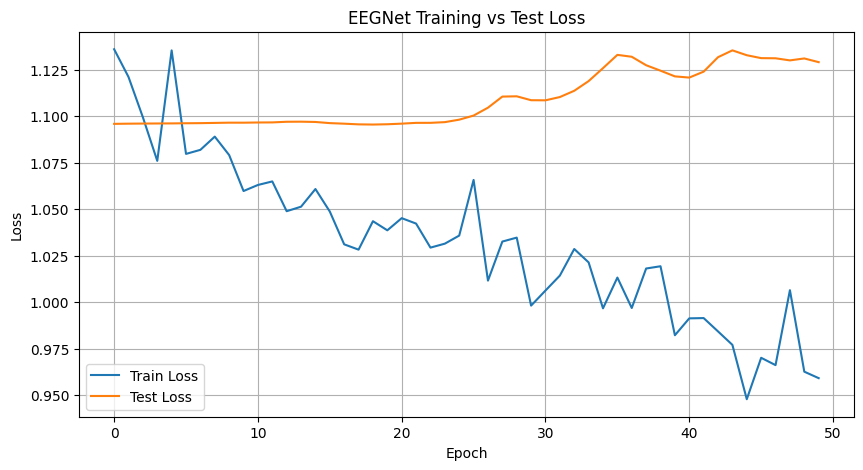

In [32]:
# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("EEGNet Training vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()